## Coordinate Categorisation

### Introduction

Coordinate categorisation allows data within a given coordinate on a cube to be categorised, notably in terms of adding a time category, for example days of week, month or year, or season membership. Such categorisation appears as an aux coord on the cube, having the same dimensions as the time coordinate.

Let's take a look at an example. In this example we will take the A1B-scenario climate futures data for North America, which contains 240 yearly timesteps from 1860 to 2099, and categorise this time coord first by year and then by decade. We will use the former categorisation to extract data from the cube from after the year 1980 and the latter categorisation to plot the cube's data on a series of per-decade aggregations.

### The Example

We will start by importing required libraries, checking versions of Iris and loading the A1B scenario data for North America.

In [10]:
import matplotlib.pyplot as plt

import iris
import iris.coord_categorisation as coord_cat

In [11]:
print('Iris version: {}'.format(iris.__version__))

Iris version: 3.10.0


In [12]:
a1b_cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
print (a1b_cube)

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
    Auxiliary coordinates:
        forecast_period                  x              -              -
    Scalar coordinates:
        forecast_reference_time     1859-09-01 06:00:00
        height                      1.5 m
    Cell methods:
        0                           time: mean (interval: 6 hour)
    Attributes:
        Conventions                 'CF-1.5'
        Model scenario              'A1B'
        STASH                       m01s03i236
        source                      'Data from Met Office Unified Model 6.05'


Now we will categorise the time coord by year and use the resultant aux coord to extract a subset of the cube that has a year value of 1980 or greater.

In [4]:
coord_cat.add_year(a1b_cube, 'time')
after_1980 = a1b_cube.extract(iris.Constraint(year=lambda cell: cell>1979))
print (after_1980)

air_temperature / (K)               (time: 120; latitude: 37; longitude: 49)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
    Auxiliary coordinates:
        forecast_period                  x              -              -
        year                             x              -              -
    Scalar coordinates:
        forecast_reference_time     1859-09-01 06:00:00
        height                      1.5 m
    Cell methods:
        0                           time: mean (interval: 6 hour)
    Attributes:
        Conventions                 'CF-1.5'
        Model scenario              'A1B'
        STASH                       m01s03i236
        source                      'Data from Met Office Unified Model 6.05'


Categorising a time coordinate by year is one of the functions built-in to `iris.coord_categorisation`, meaning that happily for us we do not have to write it ourselves. In the above block of code we do two things: add the categorised coordinate and then extract by year greater than 1980. Note that the categorised coordinate appears as an aux coord (`year`) on the cube printed above, and shares a dimension with the time coordinate, as would be expected.

Now we will also add a 'decade' aux coord to our smaller cube `after_1980` above. Unlike categorising by year, this is not a built-in function, so we will not get this for free!

Instead we will first write a function that will perform the categorisation. This function has the same generalised style as all coord categorisation functions in that it takes a coordinate and a specific point from that coordinate as its argument, and returns the point, categorised as required. This generalised style also means this, or any function like it, can be used with the general coord categorisation function `iris.coord_categorisation.add_categorised_coord`, as will be demonstrated below.

In [5]:
def decade_from_time(coord, point):
    years = coord.units.num2date(point).year
    return int(years/10) * 10

In [6]:
coord_cat.add_categorised_coord(after_1980, 'decade', 'time', decade_from_time)
print (after_1980)

air_temperature / (K)               (time: 120; latitude: 37; longitude: 49)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
    Auxiliary coordinates:
        decade                           x              -              -
        forecast_period                  x              -              -
        year                             x              -              -
    Scalar coordinates:
        forecast_reference_time     1859-09-01 06:00:00
        height                      1.5 m
    Cell methods:
        0                           time: mean (interval: 6 hour)
    Attributes:
        Conventions                 'CF-1.5'
        Model scenario              'A1B'
        STASH                       m01s03i236
        source                      'Data from Met Office Unified Model 6.0

Performing this coord categorisation has added a further aux coord to our cube, called `decade`. This contains year values rounded to the decade they sit within, such that 1995 is rounded to 1990 or 2058 is rounded to 2050. This means there are 10 data values for each unique year value within our `decade` coord, so we can aggregate these 10 values together to get one mean value for each decade within our cube.

Being able to do things like this is one of the real benefits of coord categorisation.

Let's go ahead and aggregate our cube by decade to get decadal mean values. Then we can plot these decadal means.

In [7]:
decadal_means = after_1980.aggregated_by('decade', iris.analysis.MEAN)
print (decadal_means)

air_temperature / (K)               (time: 12; latitude: 37; longitude: 49)
    Dimension coordinates:
        time                             x             -              -
        latitude                         -             x              -
        longitude                        -             -              x
    Auxiliary coordinates:
        decade                           x             -              -
        forecast_period                  x             -              -
        year                             x             -              -
    Scalar coordinates:
        forecast_reference_time     1859-09-01 06:00:00
        height                      1.5 m
    Cell methods:
        0                           time: mean (interval: 6 hour)
        1                           decade: mean
    Attributes:
        Conventions                 'CF-1.5'
        Model scenario              'A1B'
        STASH                       m01s03i236
        source                   

As makes sense, our decadal means cube has only 12 timesteps; one for each decade in the 120-year time range of our cube of years after 1980. 

Note that the values within the time coordinate are now the mean time values across the range covered by each point:

In [8]:
print (decadal_means.coord('time'))

DimCoord :  time / (hours since 1970-01-01 00:00:00, 360_day calendar)
    points: [
        1984-12-01 00:00:00, 1994-12-01 00:00:00, 2004-12-01 00:00:00,
        2014-12-01 00:00:00, 2024-12-01 00:00:00, 2034-12-01 00:00:00,
        2044-12-01 00:00:00, 2054-12-01 00:00:00, 2064-12-01 00:00:00,
        2074-12-01 00:00:00, 2084-12-01 00:00:00, 2094-12-01 00:00:00]
    bounds: [
        [1979-12-01 00:00:00, 1989-12-01 00:00:00],
        [1989-12-01 00:00:00, 1999-12-01 00:00:00],
        ...,
        [2079-12-01 00:00:00, 2089-12-01 00:00:00],
        [2089-12-01 00:00:00, 2099-12-01 00:00:00]]
    shape: (12,)  bounds(12, 2)
    dtype: float64
    standard_name: 'time'
    var_name: 'time'


To inspect the results visually, we can overlay the original time series information with the decadal means.

For simplicity we're just going to plot the values for an arbitrary geographic location:

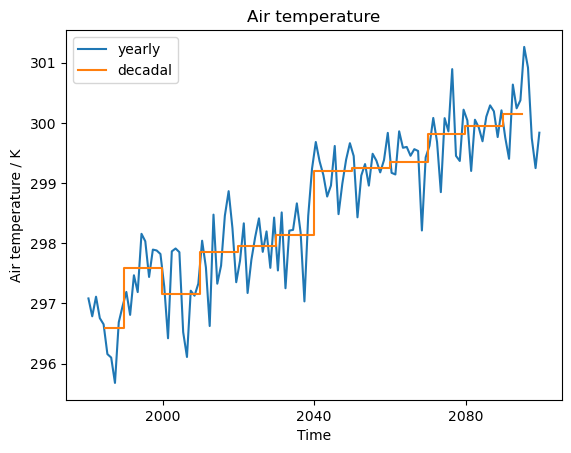

In [9]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt
qplt.plot(after_1980[:, 0, 0], label="yearly")
qplt.plot(decadal_means[:, 0, 0], drawstyle='steps-mid', label="decadal")
plt.legend()
qplt.show()
